# Progressive GANS


64 x 64 with no pre model. It appears that the results are more varied.

In [0]:
# https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

from __future__ import print_function
import argparse
import os
import glob
import shutil
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter

import torchvision

import torchvision.datasets as dset
from torch.utils.data import Dataset

import torchvision.transforms as transforms
import torchvision.utils as vutils

%matplotlib inline

In [2]:
# mounts the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Parameters

In [3]:
# Set random seed for reproducibility
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED)

# images
PARENT_DIR = '/content/drive/My Drive/repos/art_generator/'
IMG_DIR = PARENT_DIR + 'data_raw/art/all/'
IMG_SIZE = 64
N_CHANNELS = 3

# graph
GEN_INPUT_SIZE = 100
N_LAYERS = int(np.log(IMG_SIZE) / np.log(2)) - 1
N_GEN_CHANNELS = 128
N_DISC_CHANNELS = 128
beta1 = 0.5

# training
N_EPOCHS = 1000
LR = 0.0002
N_WORKERS = 2
BATCH_SIZE = 16
ngpu = 1

# checkpoints and logs
CHECKPOINT_TYPE = 'prev_checkpoint' # prev_model will load the previous model, prev_checkpoint will load the last checkpoint, none will do none. 
LOGDIR = PARENT_DIR + 'data_out/logs/size-' + str(IMG_SIZE) + '/'

print('Number of layers: ' + str(N_LAYERS))

Number of layers: 5


## Data Setup

### Dataset

In [4]:
# gets the list of images that are equal to or larger than our image output size 
img_list = glob.glob(IMG_DIR + '*')
print('Number of all images: %d' % len(img_list))
img_list = [img for img in img_list if min(Image.open(img).size) >= IMG_SIZE]
print('Number of images in size range: %d' % len(img_list))

Number of all images: 1763
Number of images in size range: 1763


In [0]:
# a custom dataset class for reading in our images from the list
class ReadFromList(Dataset):

    def __init__(self, img_list, transform=None):
        self.samples = img_list
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image = Image.open(self.samples[idx]).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return (image, 0)

In [6]:
# makes the dataset and data loader
dataset = ReadFromList(img_list, transform=transforms.Compose([
                                    transforms.Resize(IMG_SIZE),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.CenterCrop(IMG_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])
                        )

dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
print('Size of dataset: %d' % len(dataloader.dataset.samples))

Size of dataset: 1763


### Cuda Device

In [0]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### Image Check

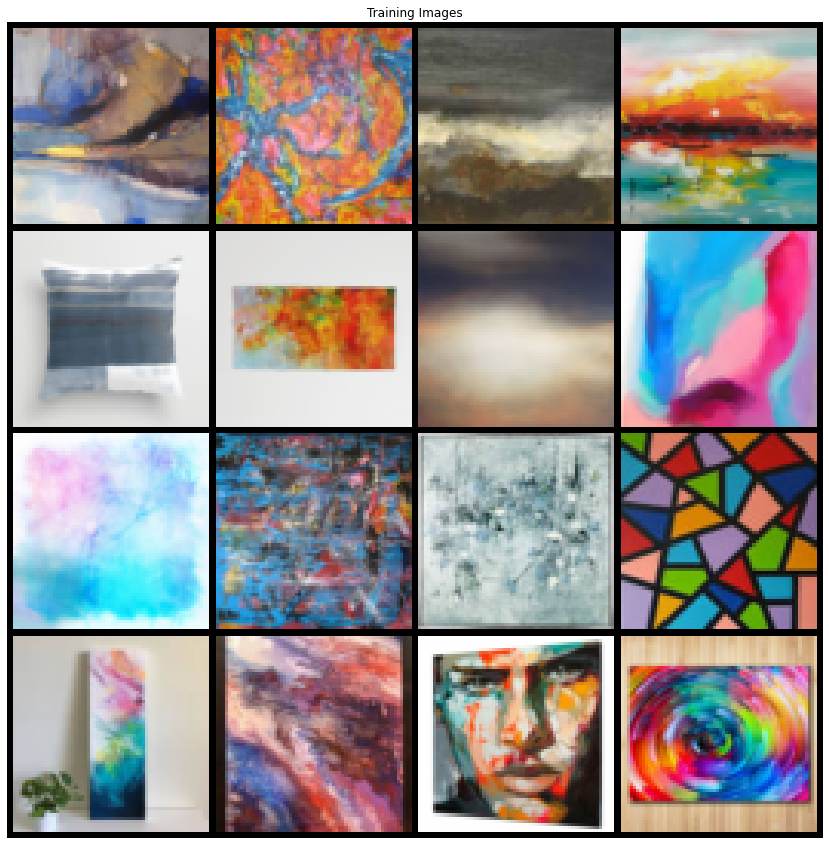

In [8]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True, nrow=4).cpu(),(1,2,0)))

### Sets Weights

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Model Setup

### Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu, n_layers):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.n_layers = n_layers

        self.layers = nn.ModuleList([nn.ConvTranspose2d(GEN_INPUT_SIZE, N_GEN_CHANNELS * 2, 4, 1, 0, bias=False)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS * 2, 4, 2, 1, bias=False) for i in range(self.n_layers - 3)])
        self.layers.extend([nn.ConvTranspose2d(N_GEN_CHANNELS * 2, N_GEN_CHANNELS, 4, 2, 1, bias=False),
                            nn.ConvTranspose2d(N_GEN_CHANNELS, N_CHANNELS, 4, 2, 1, bias=False)])                   
                           
        self.batch1 = nn.BatchNorm2d(N_GEN_CHANNELS)
        self.batch2 = nn.BatchNorm2d(N_GEN_CHANNELS * 2)

        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, name in enumerate(self.layers):
            x = self.layers[i](x)

            if self.layers[i].out_channels == N_GEN_CHANNELS * 2:
                x = self.batch2(x)
                x = self.relu(x)
            elif self.layers[i].out_channels == N_GEN_CHANNELS:
                x = self.batch1(x)
                x = self.relu(x)
            else:
                x = self.tanh(x)

        return x

In [11]:
# Create the generator
netG = Generator(ngpu, N_LAYERS).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (layers): ModuleList(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (batch1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, n_layers):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.n_layers = n_layers

        self.layers = nn.ModuleList([nn.Conv2d(N_CHANNELS, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False)])
        self.layers.extend([nn.Conv2d(N_DISC_CHANNELS * 2, N_DISC_CHANNELS * 2, 4, 2, 1, bias=False) for i in range(self.n_layers - 2)])
        self.layers.append(nn.Conv2d(N_DISC_CHANNELS * 2, 1, 4, 1, 0, bias=False))
                           
        self.batch2 = nn.BatchNorm2d(N_DISC_CHANNELS * 2)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        for i, name in enumerate(self.layers):
            x = self.layers[i](x)

            if i == 0:
                x = self.LeakyReLU(x)            
            elif self.layers[i].out_channels == N_DISC_CHANNELS * 2:
                x = self.batch2(x)
                x = self.LeakyReLU(x)
            else:
                x = self.sigmoid(x)

        return x

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu, N_LAYERS).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (layers): ModuleList(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (2): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakyReLU): LeakyReLU(negative_slope=0.2)
  (sigmoid): Sigmoid()
)

### Loss Functions and Optimizers

In [0]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, GEN_INPUT_SIZE, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(beta1, 0.999))

### Loads Checkpoint

In [15]:
if CHECKPOINT_TYPE == 'prev_model':
    prev_model_path = PARENT_DIR + 'data_out/logs/size-' + str(int(IMG_SIZE / 2)) + '/checkpoint.pt'
    checkpoint = torch.load(prev_model_path)

    # Generator 1, x, 2
    # applies the weights to the needed layers
    for layer in range(N_LAYERS - 3):
        netG.state_dict()['layers.' + str(layer) + '.weight'] = checkpoint['netG_state']['layers.' + str(layer) + '.weight']

    # # freezes the layers
    # for i, param in enumerate(netG.parameters()):
    #     if i < N_LAYERS - 3:
    #         param.requires_grad = False

    # resets the optimizer with the new parameter values
    optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(beta1, 0.999))

    # Discriminator 1, x, 1
    for layer in range(N_LAYERS - 2):
        netD.state_dict()['layers.' + str(layer) + '.weight'] = checkpoint['netD_state']['layers.' + str(layer) + '.weight']

    # # freezes the layers
    # for i, param in enumerate(netD.parameters()):
    #     if i < N_LAYERS - 2:
    #         param.requires_grad = False


    epoch_counter = 1

elif CHECKPOINT_TYPE == 'prev_checkpoint':
    # loads the model weights
    checkpoint = torch.load(LOGDIR + 'checkpoint.pt')
    netG.load_state_dict(checkpoint['netG_state'])
    optimizerG.load_state_dict(checkpoint['optimizerG'])
    netD.load_state_dict(checkpoint['netD_state'])
    optimizerD.load_state_dict(checkpoint['optimizerD'])
    print('Checkpoint Loaded')
    
    # loads the epoch counter
    with open(LOGDIR + 'itercount.txt', 'r') as f:
        epoch_counter = int(f.read())
    # moves it up one becuase it's currenlty at the last epoch we did
    epoch_counter += 1

elif CHECKPOINT_TYPE == 'none':
    # remove all previous logs
    try:
        shutil.rmtree(LOGDIR)
    except FileNotFoundError:
        print('No log folder found')

    epoch_counter = 1
else:
    print('Failed to specify a type')

Checkpoint Loaded


## Training

In [16]:
# Training Loop
writer = SummaryWriter(LOGDIR)

# Lists to keep track of progress
img_list = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(N_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)

        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

    # Save the loss for the generator and discriminator
    writer.add_scalar('Loss/Gen', errG.item(), epoch_counter)
    writer.add_scalar('Loss/Disc', errD.item(), epoch_counter)

    # print the status
    print('EPOCH: [%d/%d] BATCH: [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch_counter, N_EPOCHS, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    # saves a checkpoint        
    checkpoint = {'netG_state': netG.state_dict(), 'optimizerG': optimizerG.state_dict(),
                    'netD_state': netD.state_dict(), 'optimizerD': optimizerD.state_dict()}
    torch.save(checkpoint, LOGDIR + 'checkpoint.pt')
    
    # saves the epoch counter
    with open(LOGDIR + '/itercount.txt', 'w') as f:
        f.write(str(epoch_counter))

    # Saves an image so we can view the progression
    with torch.no_grad():
        output = netG(fixed_noise).detach().cpu()
    grid = torchvision.utils.make_grid(output[8])
    writer.add_image('image_epoch_' + str(epoch_counter), grid)

    # increments our counter
    epoch_counter += 1

writer.close()

Starting Training Loop...


/pytorch/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


EPOCH: [968/1000] BATCH: [110/111]	Loss_D: 0.1321	Loss_G: 12.5756	D(x): 0.8828	D(G(z)): 0.0000 / 0.0000
EPOCH: [969/1000] BATCH: [110/111]	Loss_D: 0.0211	Loss_G: 10.0281	D(x): 0.9792	D(G(z)): 0.0000 / 0.0000
EPOCH: [970/1000] BATCH: [110/111]	Loss_D: 0.1326	Loss_G: 13.7106	D(x): 0.8898	D(G(z)): 0.0000 / 0.0000
EPOCH: [971/1000] BATCH: [110/111]	Loss_D: 4.5961	Loss_G: 2.3115	D(x): 0.0127	D(G(z)): 0.0002 / 0.4656
EPOCH: [972/1000] BATCH: [110/111]	Loss_D: 1.5543	Loss_G: 2.2956	D(x): 0.4272	D(G(z)): 0.0008 / 0.3485
EPOCH: [973/1000] BATCH: [110/111]	Loss_D: 0.0754	Loss_G: 8.8452	D(x): 0.9282	D(G(z)): 0.0002 / 0.0002
EPOCH: [974/1000] BATCH: [110/111]	Loss_D: 0.0017	Loss_G: 8.7395	D(x): 0.9989	D(G(z)): 0.0006 / 0.0004
EPOCH: [975/1000] BATCH: [110/111]	Loss_D: 4.6389	Loss_G: 3.5283	D(x): 0.0234	D(G(z)): 0.0001 / 0.0536
EPOCH: [976/1000] BATCH: [110/111]	Loss_D: 2.2974	Loss_G: 0.6862	D(x): 0.1433	D(G(z)): 0.0010 / 0.5205
EPOCH: [977/1000] BATCH: [110/111]	Loss_D: 0.0217	Loss_G: 8.6741	D(x):

KeyboardInterrupt: ignored

## Results

### Batch of Real and Fake Images

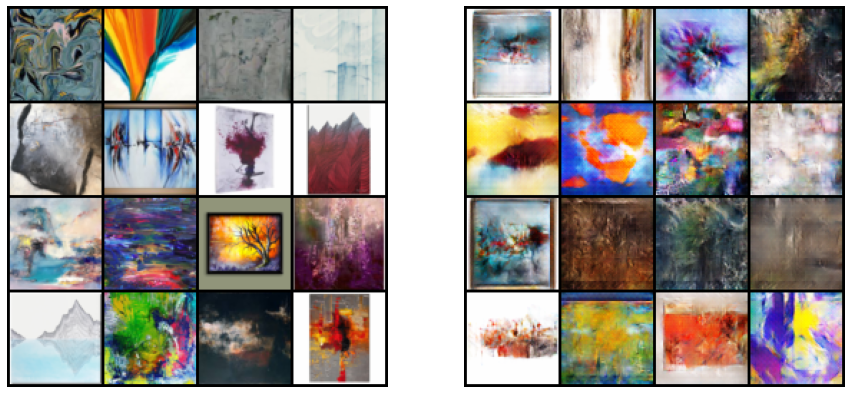

In [17]:
# makes the image list
with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake[:16], padding=2, normalize=True, nrow=4))

# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True, nrow=4).cpu(),(1, 2, 0)))

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

### Random Image

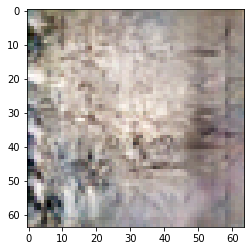

In [27]:
# helper function for converting images to a normal range
def img_scale(img_tensor):
    min_value = img_tensor.min()
    span = img_tensor.max() - img_tensor.min()
    img_tensor = (img_tensor - min_value) / span
    img_tensor = np.transpose(img_tensor)

    return img_tensor

noise = torch.randn(b_size, GEN_INPUT_SIZE, 1, 1, device=device)
output = netG(noise).detach().cpu()
plt.imshow(img_scale(output[0]))